CIFAR10 是另外一個 dataset， 和 mnist 一樣，有十種類別（飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車）

https://www.cs.toronto.edu/~kriz/cifar.html


In [1]:
import keras
from keras.models import Sequential
from PIL import Image
import numpy as np
import tarfile


Using TensorFlow backend.


In [2]:
# 讀取 dataset
# 只有 train 和 test 沒有 validation
import pickle
train_X=[]
train_y=[]
tar_gz = "../Week06/cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend(result['data']/255)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data']/255)
        test_y=np.int32(result['labels'])
train_Y = np.eye(10)[train_y]
test_Y = np.eye(10)[test_y]
validation_data = (test_X[:1000], test_Y[:1000])
test_data = (test_X[1000:], test_Y[1000:])


load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


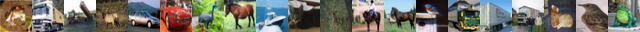

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [3]:
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X_reshape = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X_reshape = int_X_reshape.swapaxes(0,1).reshape(32,-1, 3)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

將之前的 cnn model 套用過來看看

In [ ]:
# %load ../Week06/q_cifar10_cnn.py
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
model = Sequential()
model.add(Reshape((3, 32, 32), input_shape=(3*32*32,) ))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", data_format='channels_first'))
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu", data_format='channels_first'))
model.add(MaxPool2D())
model.add(Reshape((-1,)))
model.add(Dense(units=1024, activation="relu"))
model.add(Dense(units=10, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_X, train_Y, validation_data=validation_data, batch_size=100, epochs=10)
rtn = model.evaluate(*test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
showX(test_X[:15])
predict_y = model.predict_classes(test_X[:15], verbose=False)
print(name_array[predict_y])
print(name_array[test_y[:15]])

In [ ]:
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Dropout
model = Sequential()
model.add(Reshape((3, 32, 32), input_shape=(3*32*32,) ))
model.add(Conv2D(32, 3, padding='same', activation="relu", data_format='channels_first'))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding='same', activation="relu", data_format='channels_first'))
model.add(MaxPool2D())
model.add(Reshape((-1,)))
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(rate=0.4))
model.add(Dense(units=10, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_X, train_Y, validation_data=validation_data, batch_size=100, epochs=10)
rtn = model.evaluate(*test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
model.fit(train_X, train_Y, validation_data=validation_data, batch_size=100, epochs=10)
rtn = model.evaluate(*test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
showX(test_X[:15])
predict_y = model.predict_classes(test_X[:15], verbose=False)
print(name_array[predict_y])
print(name_array[test_y[:15]])

不同的 activation
https://keras.io/activations/

In [5]:
# 先定義一個工具
def add_layers(model, *layers):
    for l in layers:
        model.add(l)

In [ ]:
import keras
from keras.engine.topology import Layer
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Dropout

def MyConv2D(filters, kernel_size, **kwargs):
    return (Conv2D(filters=filters, kernel_size=kernel_size, 
                   padding='same',  data_format='channels_first', **kwargs),
            Activation("elu"))
model = Sequential()
add_layers( model,
    Reshape((3, 32, 32), input_shape=(3*32*32,)),
    *MyConv2D(32, 3),
    MaxPool2D(),
    *MyConv2D(64, 3),
    MaxPool2D(),
    Reshape((-1,)),
    Dense(units=1024, activation="elu"),
    Dropout(rate=0.4),
    Dense(units=10, activation="softmax")
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_X, train_Y, validation_data=validation_data, batch_size=100, epochs=10)
rtn = model.evaluate(*test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Dropout, BatchNormalization
# 先處理資料

#GCN
train_X_mean = np.mean(train_X, axis=0, keepdims=True)
train_X_std = np.std(train_X, axis=0, keepdims=True)
preprocessed_train_X = (train_X-train_X_mean)/train_X_std
preprocessed_test_X = (test_X-train_X_mean)/train_X_std
preprocessed_validation_data = (preprocessed_test_X[:1000], test_Y[:1000])
preprocessed_test_data = (preprocessed_test_X[1000:], test_Y[1000:])


def MyConv2D(filters, kernel_size, **kwargs):
    return (Conv2D(filters=filters, kernel_size=kernel_size, 
                   padding='same',  data_format='channels_first', **kwargs),
            Activation("relu"))
def add_layers(model, *layers):
    for l in layers:
        model.add(l)
model = Sequential()
add_layers( model,
    Reshape((3, 32, 32), input_shape=(3*32*32,)),
    *MyConv2D(32, 3),
    MaxPool2D(),
    *MyConv2D(64, 3),
    MaxPool2D(),
    Reshape((-1,)),
    Dense(units=1024, activation="relu"),
    Dropout(rate=0.4),
    Dense(units=10, activation="softmax")
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(preprocessed_train_X, train_Y, validation_data=preprocessed_validation_data, 
          batch_size=100, epochs=10)
rtn = model.evaluate(*preprocessed_test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Dropout, BatchNormalization
# 先處理資料

#GCN
train_X_mean = np.mean(train_X, axis=0, keepdims=True)
train_X_std = np.std(train_X, axis=0, keepdims=True)
preprocessed_train_X = (train_X-train_X_mean)/train_X_std
preprocessed_test_X = (test_X-train_X_mean)/train_X_std
preprocessed_validation_data = (preprocessed_test_X[:1000], test_Y[:1000])
preprocessed_test_data = (preprocessed_test_X[1000:], test_Y[1000:])


def MyConv2D(filters, kernel_size, **kwargs):
    return (Conv2D(filters=filters, kernel_size=kernel_size, 
                   padding='same',  data_format='channels_first', **kwargs),
            BatchNormalization(axis=1),
            Activation("relu"))
def add_layers(model, *layers):
    for l in layers:
        model.add(l)
model = Sequential()
add_layers( model,
    Reshape((3, 32, 32), input_shape=(3*32*32,)),
    *MyConv2D(32, 3),
    MaxPool2D(),
    *MyConv2D(64, 3),
    MaxPool2D(),
    Reshape((-1,)),
    Dense(units=1024, activation="relu"),    
    Dropout(0.4),
    Dense(units=10, activation="softmax")
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(preprocessed_train_X, train_Y, validation_data=preprocessed_validation_data, 
          batch_size=100, epochs=10)
rtn = model.evaluate(*preprocessed_test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
model.fit(preprocessed_train_X, train_Y, validation_data=preprocessed_validation_data, 
          batch_size=100, epochs=10)
rtn = model.evaluate(*preprocessed_test_data)
print("\ntest accuracy=", rtn[1])

In [ ]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    X = X.T
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix.T
# ZCAMatrix = zca_whitening_matrix(X0)
# new_train_X= ((train_X-train_X_mean)/train_X_std) @ ZCAMatrix

In [46]:
# 參考 https://keras.io/preprocessing/image/

# 輸入改成 tensor4
train_X = train_X.reshape(-1, 3, 32, 32)
test_X = test_X.reshape(-1, 3, 32, 32)

def MyConv2D(filters, kernel_size, **kwargs):
    return (Conv2D(filters=filters, kernel_size=kernel_size, 
                   padding='same',  data_format='channels_first', **kwargs),
            BatchNormalization(axis=1),
            Activation("relu"))
model = Sequential()
add_layers( model,
    *MyConv2D(32, 3, input_shape=(3,32,32)),
    MaxPool2D(),
    *MyConv2D(64, 3),
    MaxPool2D(),
    Reshape((-1,)),
    Dense(units=1024, activation="relu"),    
    Dropout(0.4),
    Dense(units=10, activation="softmax")
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 使用 keras 的功能
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    data_format="channels_first")

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_X)


p_train_X, p_train_Y = datagen.flow(train_X, train_Y, batch_size=len(train_X), shuffle=False).next()
# 順序都沒變
assert (p_train_Y == train_Y).all()

p_test_X, p_test_Y = datagen.flow(test_X, test_Y, batch_size=len(test_X), shuffle=False).next()
# 順序都沒變
assert (p_test_Y == test_Y).all()
# 不需要這兩個
del p_train_Y, p_test_Y


p_validation_data = (p_test_X[:1000], test_Y[:1000])
p_test_data = (p_test_X[1000:], test_Y[1000:])
model.fit(p_train_X, train_Y, validation_data=p_validation_data, 
          batch_size=100, epochs=10)
rtn = model.evaluate(*p_test_data)
print("\ntest accuracy=", rtn[1])


Train on 50000 samples, validate on 1000 samples
Epoch 1/10
50000/50000 [==============================] - 21s - loss: 1.7873 - acc: 0.3685 - val_loss: 1.2386 - val_acc: 0.5590
Epoch 2/10
50000/50000 [==============================] - 19s - loss: 1.1039 - acc: 0.6151 - val_loss: 0.9841 - val_acc: 0.6390
Epoch 3/10
50000/50000 [==============================] - 19s - loss: 0.8625 - acc: 0.6995 - val_loss: 0.9384 - val_acc: 0.6650
Epoch 4/10
50000/50000 [==============================] - 20s - loss: 0.6853 - acc: 0.7584 - val_loss: 0.9046 - val_acc: 0.6880
Epoch 5/10
50000/50000 [==============================] - 19s - loss: 0.5213 - acc: 0.8183 - val_loss: 0.9589 - val_acc: 0.6690
Epoch 6/10
50000/50000 [==============================] - 19s - loss: 0.3697 - acc: 0.8704 - val_loss: 1.0565 - val_acc: 0.6830
Epoch 7/10
50000/50000 [==============================] - 19s - loss: 0.2568 - acc: 0.9126 - val_loss: 1.1430 - val_acc: 0.6710
Epoch 8/10
50000/50000 [==============================]

使用動態資料處理
```python
# fits the model on batches with real-time data augmentation:
train_generator = datagen.flow(train_X, train_Y, batch_size=100, shuffle=False)
test_generator = datagen.flow(*test_data, batch_size=100, shuffle=False)
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_X), 
                    #validation_data=datagen.flow(*validation_data, batch_size=100),
                    #validation_steps=1000,
                    epochs=10)
rtn = model.evaluate_generator(test_generator, steps=9000)
```

In [7]:
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Dropout, BatchNormalization
# 輸入改成 tensor4
train_X = train_X.reshape(-1, 3, 32, 32)
test_X = test_X.reshape(-1, 3, 32, 32)

def MyConv2D(filters, kernel_size, **kwargs):
    return (Conv2D(filters=filters, kernel_size=kernel_size, 
                   padding='same',  data_format='channels_first', **kwargs),
            BatchNormalization(axis=1),
            Activation("elu"))
model = Sequential()
add_layers( model,
    *MyConv2D(64, 3, input_shape=(3,32,32)),
    *MyConv2D(64, 3),
    MaxPool2D(),
    *MyConv2D(128, 3),
    *MyConv2D(128, 3),
    MaxPool2D(),
    *MyConv2D(256, 3),
    *MyConv2D(256, 3),
    Reshape((-1,)),
    Dense(units=1024),
    BatchNormalization(),
    Activation("elu"),
    Dropout(0.4),
    Dense(units=10, activation="softmax")
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 使用 keras 的功能
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    data_format="channels_first")

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_X)


p_train_X, p_train_Y = datagen.flow(train_X, train_Y, batch_size=len(train_X), shuffle=False).next()
# 順序都沒變
assert (p_train_Y == train_Y).all()

p_test_X, p_test_Y = datagen.flow(test_X, test_Y, batch_size=len(test_X), shuffle=False).next()
# 順序都沒變
assert (p_test_Y == test_Y).all()
# 不需要這兩個
del p_train_Y, p_test_Y


p_validation_data = (p_test_X[:1000], test_Y[:1000])
p_test_data = (p_test_X[1000:], test_Y[1000:])
model.fit(p_train_X, train_Y, validation_data=p_validation_data, 
          batch_size=100, epochs=10)
rtn = model.evaluate(*p_test_data)
print("\ntest accuracy=", rtn[1])


Train on 50000 samples, validate on 1000 samples
Epoch 1/10
50000/50000 [==============================] - 241s - loss: 1.2842 - acc: 0.5796 - val_loss: 1.0378 - val_acc: 0.6550
Epoch 2/10
50000/50000 [==============================] - 237s - loss: 0.8303 - acc: 0.7150 - val_loss: 1.0894 - val_acc: 0.6400
Epoch 3/10
50000/50000 [==============================] - 237s - loss: 0.6883 - acc: 0.7626 - val_loss: 0.9810 - val_acc: 0.6650
Epoch 4/10
50000/50000 [==============================] - 237s - loss: 0.5946 - acc: 0.7913 - val_loss: 1.4068 - val_acc: 0.5840
Epoch 5/10
50000/50000 [==============================] - 237s - loss: 0.5295 - acc: 0.8145 - val_loss: 1.0667 - val_acc: 0.6780
Epoch 6/10
50000/50000 [==============================] - 237s - loss: 0.4687 - acc: 0.8337 - val_loss: 0.9418 - val_acc: 0.6960
Epoch 7/10
50000/50000 [==============================] - 237s - loss: 0.4149 - acc: 0.8522 - val_loss: 0.7590 - val_acc: 0.7650
Epoch 8/10
50000/50000 [========================